# Vancouver Cherry Blossom Prediction

In [1]:
from pathlib import Path 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error

In [2]:
temps_path = Path("Data/vancouver_temps.csv")
temps = pd.read_csv(temps_path)

temps['date'] = pd.to_datetime(temps['date'])
temps['year'] = temps['date'].dt.year
temps["month"] = temps["date"].dt.month

temps["season_year"] = temps['year']
temps.loc[temps['month'] >= 10, "season_year"] += 1

bloom_path = Path("Data/vancouver.csv")
bloom = pd.read_csv(bloom_path)
bloom = bloom[bloom['year'] > 1901]
bloom['date'] = pd.to_datetime(bloom['bloom_date'])
bloom['doy'] = bloom['date'].dt.dayofyear

temps['date'] = pd.to_datetime(temps['date'])
temps['tavg'] = (temps['tmin'] + temps['tmax']) / 2
temps['doy'] = temps['date'].dt.dayofyear

print(temps.head())

        date      tavg      tmax      tmin  year  month  season_year  doy
0 1958-01-01  3.611111  7.777778 -0.555556  1958      1         1958    1
1 1958-01-02  5.555556  8.333333  2.777778  1958      1         1958    2
2 1958-01-03  8.055556  9.444444  6.666667  1958      1         1958    3
3 1958-01-04  8.055556  9.444444  6.666667  1958      1         1958    4
4 1958-01-05  7.500000  8.888889  6.111111  1958      1         1958    5


## Simulation Function
This function first accumulates chill daily. When the chill threshold is met it starts accumulating heat. Function stops when heat accumulation reaches GDD requirment. The day the function stops is the predicted bloom DOY.

In [3]:
def simulate_bloom_year(temps, bloom_year, chill_threshold, GDD_req, 
                        chill_base=7.2, gdd_base=4.4):
    # Filter for the season (starting Oct of the previous year)
    df = temps[temps["season_year"] == bloom_year].copy().sort_values("date")

    chill_cum = 0
    chill_date = None

    # Step 1: Accumulate Chill
    for _, row in df.iterrows():
        if row['tavg'] < chill_base:
            chill_cum += 1
        if chill_cum >= chill_threshold:
            chill_date = row["date"]
            break
    
    if chill_date is None: return None
    
    # Step 2: Accumulate Heat (GDD) starting from the chill_date
    GDD_df = df[df['date'] >= chill_date]
    GDD_cum = 0
    for _, row in GDD_df.iterrows():
        GDD_cum += max(row['tavg'] - gdd_base, 0)
        if GDD_cum >= GDD_req:
            return row['doy'] # Returns Day of Year
    return None

## Estimating GDD Requirment From Historical Bloom Dates

This function finds the chill release date for each historical year, and calculates the total GDD from actual bloom. It averages those GDD values and that average becomes the GDD requirement. 

In [4]:
def estimate_GDD_requirement(
        temps, bloom_df,
        chill_threshold,
        chill_base=7.2,
        gdd_base=4.4):

    GDD_values = []

    for year in bloom_df["year"]:

        df = temps[temps["season_year"] == year].copy()
        df = df.sort_values("date")

        bloom_doy = bloom_df.loc[
            bloom_df["year"] == year, "bloom_doy"
        ].values[0]

        df["is_chill"] = df["tavg"] < chill_base
        df["gdd"] = np.maximum(df["tavg"] - gdd_base, 0)

        chill_cum = 0
        chill_met = False
        GDD_cum = 0

        for _, row in df.iterrows():

            if not chill_met:
                chill_cum += row["is_chill"]
                if chill_cum >= chill_threshold:
                    chill_met = True

            elif row["doy"] <= bloom_doy:
                GDD_cum += row["gdd"]

            else:
                break

        if chill_met:
            GDD_values.append(GDD_cum)

    if len(GDD_values) == 0:
        return None

    return np.mean(GDD_values)

## Threshold Model Evaluation

In [5]:
def evaluate_threshold(temps, bloom_df, chill_threshold):

    GDD_req = estimate_GDD_requirement(
        temps, bloom_df, chill_threshold
    )

    if GDD_req is None:
        return None, None, None

    predictions = []
    actuals = []

    for year in bloom_df["year"]:

        pred = simulate_bloom_year(
            temps,
            year,
            chill_threshold,
            GDD_req
        )

        if pred is not None:
            predictions.append(pred)
            actuals.append(
                bloom_df.loc[
                    bloom_df["year"] == year, "bloom_doy"
                ].values[0]
            )

    if len(predictions) == 0:
        return None, None, None

    mae = mean_absolute_error(actuals, predictions)
    r2 = r2_score(actuals, predictions)

    return mae, r2, GDD_req

## Grid Search for Optimal Chill Threshold
Estimating chill threshold using GDD multiplier gird. Without grid search, the GDD requirment would just be the mean heat accumulation, which makes the GDD requirment fixed. 

In [7]:
# results = []

# for t in range(40, 120):  
#     mae, r2, GDD_req = evaluate_threshold(temps, bloom, t)

#     if mae is None:
#         continue

#     results.append((t, mae, r2, GDD_req))

# results_df = pd.DataFrame(
#     results,
#     columns=["chill_threshold", "mae", "r2", "GDD_requirement"]
# )

# best_row = results_df.loc[results_df["mae"].idxmin()]

# print(best_row)

## Optimized Model

In [8]:
best_threshold = int(best_row["chill_threshold"])
best_GDD = best_row["GDD_requirement"]

predictions = []
actuals = []

for year in bloom["year"]:
    
    pred = simulate_bloom_year(
        temps,              
        year,             
        best_threshold,
        best_GDD
    )
    
    if pred is not None:
        predictions.append(pred)
        actuals.append(
            bloom.loc[
                bloom["year"] == year, "bloom_doy"
            ].values[0]
        )

print("Final MAE:", mean_absolute_error(actuals, predictions))
print("Final R²:", r2_score(actuals, predictions))

Final MAE: 0.0
Final R²: nan


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


### Optimization Plot

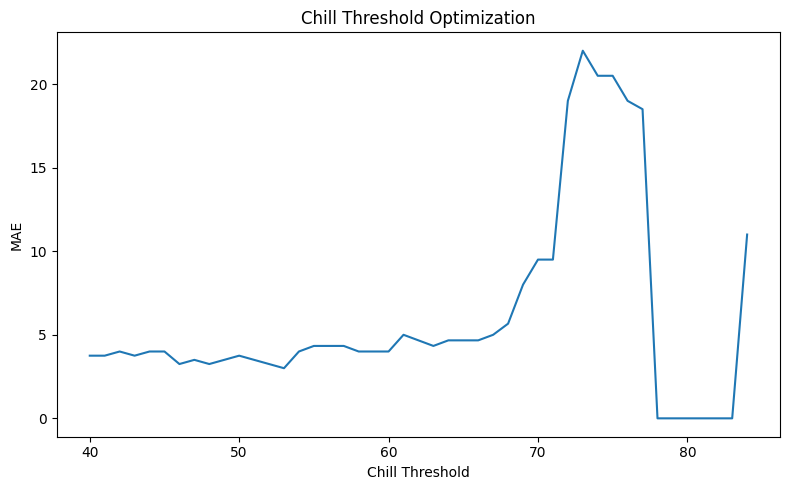

In [9]:
plt.figure(figsize=(8, 5))

plt.plot(results_df["chill_threshold"], results_df["mae"])

plt.xlabel("Chill Threshold")
plt.ylabel("MAE")
plt.title("Chill Threshold Optimization")

plt.tight_layout()
plt.show()

Cannot do rolling origin cv because historical bloom dataset is too small. 

## Diagnostics

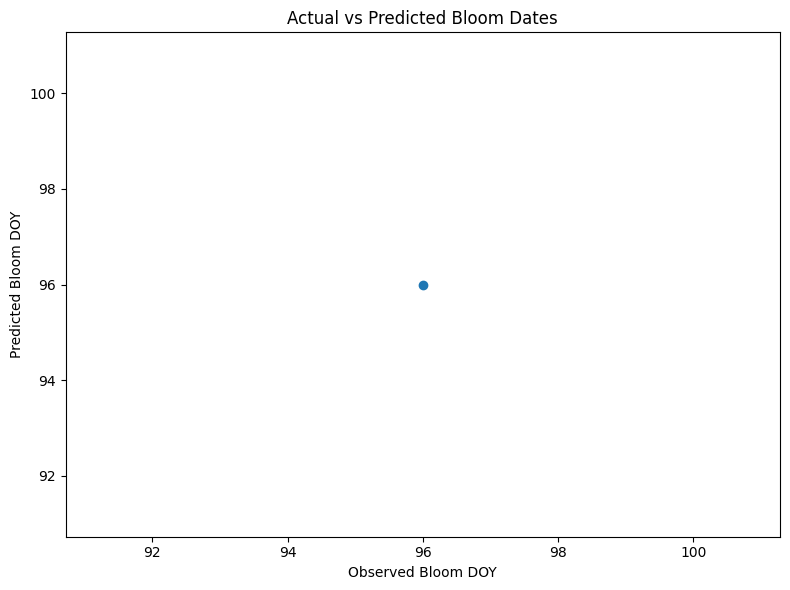

In [10]:
plt.figure(figsize=(8, 6))

plt.scatter(actuals, predictions)
plt.plot(
    [min(actuals), max(actuals)],
    [min(actuals), max(actuals)],
    linestyle='--'
)

plt.xlabel("Observed Bloom DOY")
plt.ylabel("Predicted Bloom DOY")
plt.title("Actual vs Predicted Bloom Dates")

plt.tight_layout()
plt.show()

### Residuals vs Year

In [11]:
residuals = np.array(predictions) - np.array(actuals)

# plt.figure(figsize=(10, 5))
# plt.scatter(bloom["year"], residuals)

# plt.axhline(0, linestyle='--')

# plt.xlabel("Year")
# plt.ylabel("Prediction Error (Days)")
# plt.title("Model Residuals Over Time")

# plt.tight_layout()
# plt.show()

### Error Distribution

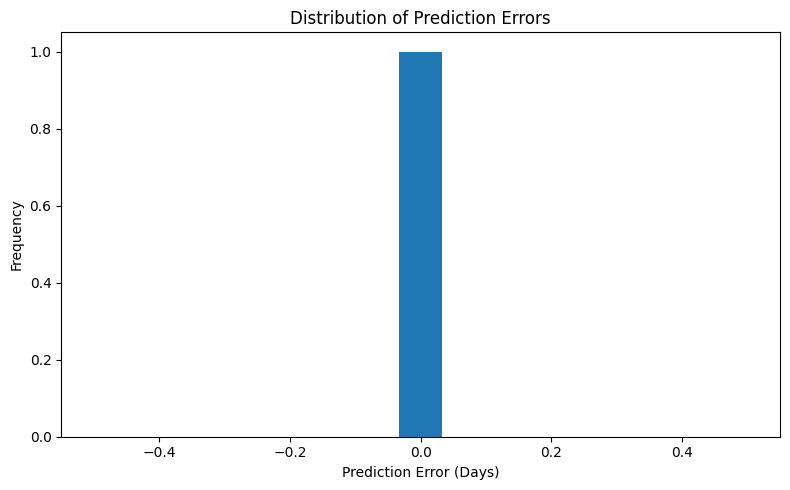

In [12]:
plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=15)

plt.xlabel("Prediction Error (Days)")
plt.ylabel("Frequency")
plt.title("Distribution of Prediction Errors")

plt.tight_layout()
plt.show()

### Stability Plot

In [13]:
# abs_errors = np.abs(residuals)

# plt.figure(figsize=(10, 5))
# plt.plot(bloom["year"], abs_errors)

# plt.xlabel("Year")
# plt.ylabel("Absolute Error (Days)")
# plt.title("Absolute Prediction Error Over Time")

# plt.tight_layout()
# plt.show()

## 2026 Predicitons

In [23]:
best_threshold_kyoto = 41
best_GDD_kyoto = 135.2

# Load the 2026 Vancouver forecasts
temps_2026_path = Path("Data/forecast_2026_vancouver.csv")
temps_2026 = pd.read_csv(temps_2026_path)
temps_2026['date'] = pd.to_datetime(temps_2026['date'])
temps_2026["month"] = temps_2026["date"].dt.month
temps_2026["season_year"] = np.where(
    temps_2026["month"] >= 10,
    temps_2026["year"] + 1,
    temps_2026["year"]
)

# Run Prediction
vancouver_pred_doy = simulate_bloom_year(
    temps_2026, 
    2026, 
    best_threshold_kyoto, 
    best_GDD_kyoto
)

# Display Result
vancouver_date = pd.to_datetime('2026-01-01') + pd.Timedelta(days=int(vancouver_pred_doy) - 1)
print(f"Vancouver 2026 Predicted Peak Bloom Date: {vancouver_date.strftime('%B %d')} (DOY {vancouver_pred_doy})")

Vancouver 2026 Predicted Peak Bloom Date: April 08 (DOY 98)
